In [1]:
import torch
import matplotlib.pyplot as plt
import networks
from visualize_utils import *
import utils
from depth_anything import dpt
import cv2
import torch
import layers
import torch.nn.functional as F
import torch.nn as nn
from einops import rearrange

/home/zhouy/miniconda3/envs/da2/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 参数设置

In [17]:
frame_indices = [0, -1, 1]

def pose_predict(models, images, outputs):
    pose_feats = {
        f_i: images[f_i + 1].unsqueeze(0) for f_i in frame_indices
    }
    for f_i in frame_indices[1:]:
        if f_i < 0:
            inputs_all = [pose_feats[f_i], pose_feats[0]]
        else:
            inputs_all = [pose_feats[0], pose_feats[f_i]]
    
        pose_inputs = [models["pose_encoder"](torch.cat(inputs_all, 1))]
        axisangle, translation = models["pose"](pose_inputs)

        outputs[("axisangle", f_i)] = axisangle
        outputs[("translation", f_i)] = translation
        outputs[("cam_T_cam", f_i)] = layers.transformation_from_parameters(
            axisangle[:, 0], translation[:, 0], invert=(f_i < 0))

K = np.array([[0.82, 0, 0.5, 0],
            [0, 1.02, 0.5, 0],
            [0, 0, 1, 0],
            [0, 0, 0, 1]], dtype=np.float32)
K[0, :] *= 320
K[1, :] *= 256
inv_K = np.linalg.pinv(K)
K = torch.from_numpy(K).cuda().unsqueeze(0)
inv_K = torch.from_numpy(inv_K).cuda().unsqueeze(0)

B = 1
T = 3
width = 320
height = 256
patch = 16
Hp = height // patch
Wp = width // patch
min_depth = 1e-3
max_depth = 150

In [3]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'


## 测试Decompose

In [13]:
encoder = networks.ResnetEncoder(18, False).to(torch.device("cuda"))
decoder = networks.DecomposeDecoder(encoder.num_ch_enc).to(torch.device("cuda"))
image_loader = ImageLoader(1, 1)
images = image_loader.batch([1,2,3])

/home/zhouy/miniconda3/envs/da2/lib/python3.9/site-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
/home/zhouy/miniconda3/envs/da2/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [14]:
feats = encoder(images)
outputs = decoder(feats, images)

In [15]:
T = [outputs["A"].unsqueeze(2), outputs["A"].unsqueeze(2)]
h = torch.cat(T, dim=2)
h.shape

torch.Size([3, 3, 2, 256, 320])

## 测试DPTV2

In [2]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'

model_configs = {
    'vits': {'encoder': 'vits', 'features': 64, 'out_channels': [48, 96, 192, 384]},
    'vitb': {'encoder': 'vitb', 'features': 128, 'out_channels': [96, 192, 384, 768]},
    'vitl': {'encoder': 'vitl', 'features': 256, 'out_channels': [256, 512, 1024, 1024]},
    'vitg': {'encoder': 'vitg', 'features': 384, 'out_channels': [1536, 1536, 1536, 1536]}
}

encoder = 'vits' # or 'vits', 'vitb', 'vitg'

model = networks.depth.Depth(**model_configs[encoder], device=DEVICE)
model.load_state_dict(torch.load(f'checkpoints/depth_anything_v2_{encoder}.pth', map_location='cpu'))
model = model.to(DEVICE)
image_loader = ImageLoader(1, 1)
images = image_loader.batch([1,2,3])

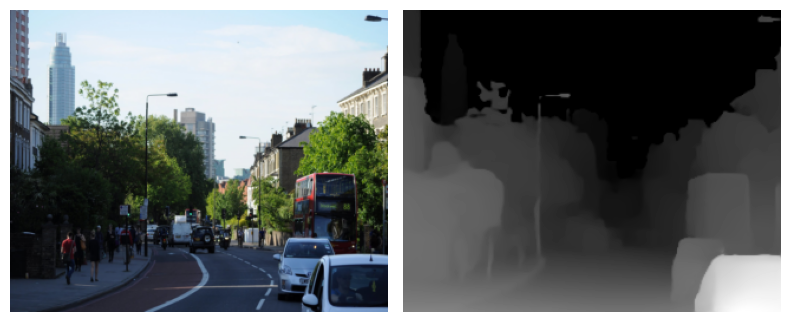

In [4]:
image_path = get_image_path(5, 3, 1)
image_path = './demo01.jpg'
image = load_image(image_path, 'cuda')
depth = model(image)
plot_images([image, depth])


In [5]:
from peft import LoraConfig, get_peft_model

lora_config = LoraConfig(
    r=10,  # 低秩维度，平衡效率和性能
    lora_alpha=20,  # 缩放因子，通常为 2*r
    target_modules=["qkv"],  # 针对 ViT 层
    lora_dropout=0.05,  # dropout 防止过拟合
    bias="none",  # 不调整偏置
    task_type=None  # 自定义任务类型
)
model = get_peft_model(model, lora_config)
model.print_trainable_parameters()

/home/zhouy/miniconda3/envs/da2/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


trainable params: 184,320 || all params: 24,969,409 || trainable%: 0.7382


## 测试DRM

In [ ]:
def extract_samples(suppressed_seq, M_seq, num_pos=128, num_neg=128, T=5):
    B, T, C, H, W = suppressed_seq.shape
    flat_feat = suppressed_seq.view(B, T, C, -1)  # [B, T, C, HW]
    flat_M = M_seq.view(B, T, 1, -1)
    mid = int(T / 2)
    
    # 正样本：相邻帧 (t-1, t+1) 非反射平均 [B, C]
    non_reflect_mask = (flat_M[:, mid-1:mid+1] < 0.5).squeeze(2).float()  # 中间帧相邻
    pos_indices = torch.multinomial(non_reflect_mask.view(B, -1), num_pos, replacement=True)
    pos_feat = flat_feat[:, mid-1:mid+1].view(B, (T-2)*C, -1)  # 时空展平
    pos = torch.gather(pos_feat, 2, pos_indices.unsqueeze(1).expand(-1, (T-2)*C, -1)).mean([1,2])
    
    # 负样本：当前序列反射平均 [B, C]
    reflect_mask = (flat_M > 0.5).squeeze(2).float().view(B, -1)
    neg_indices = torch.multinomial(reflect_mask, num_neg, replacement=True)
    neg_feat = flat_feat.view(B, T*C, -1)
    neg = torch.gather(neg_feat, 2, neg_indices.unsqueeze(1).expand(-1, T*C, -1)).mean([1,2])
    
    return pos, neg

In [2]:
encoder = networks.ResnetEncoder(18, False).to(torch.device("cuda"))
decoder = networks.DecomposeDecoder(encoder.num_ch_enc).to(torch.device("cuda"))
image_loader = ImageLoader(1, 1)
images = image_loader.batch([1,2,3])
feats = encoder(images)
outputs = decoder(feats, images)
drm = networks.DynamicReflectionModule().to(torch.device("cuda"))
drm_input_A = outputs["A"].unsqueeze(2).permute(2, 1, 0, 3, 4)
drm_input_M = outputs["M"].unsqueeze(2).permute(2, 1, 0, 3, 4)
drm_output = drm(drm_input_A, drm_input_M)

/home/zhouy/miniconda3/envs/da2/lib/python3.9/site-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
/home/zhouy/miniconda3/envs/da2/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [11]:
import torch.nn as nn
import torch
import math
from einops import rearrange
import os

a = torch.randn(8, 3, 256, 320)
b = torch.randn(8, 3, 256, 320)
c = [a, b]
torch.stack(c, dim=1).shape

torch.Size([8, 2, 3, 256, 320])

## 测试DPTV2(transformers)

In [1]:
from transformers import AutoImageProcessor, AutoModelForDepthEstimation, DepthAnythingForDepthEstimation
import torch

/home/zhouy/miniconda3/envs/da2/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
model = DepthAnythingForDepthEstimation.from_pretrained("checkpoints/Depth-Anything-V2-Small-hf").to('cuda')

In [ ]:
image_path = './demo01.jpg'
image = load_image(image_path, 'cuda')
depth = model(image)
depth.shape
# plot_images([image, depth])


In [4]:
torch.save(model.state_dict(), 'model.pth')

In [5]:
model_state_dict = torch.load('model.pth')
model = DepthAnythingForDepthEstimation()
model.load_state_dict(model_state_dict)

TypeError: __init__() missing 1 required positional argument: 'config'

## 其他

In [1]:
import torch.nn as nn
import torch
from visualize_utils import *
import matplotlib.pyplot as plt

/home/zhouy/miniconda3/envs/da2/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


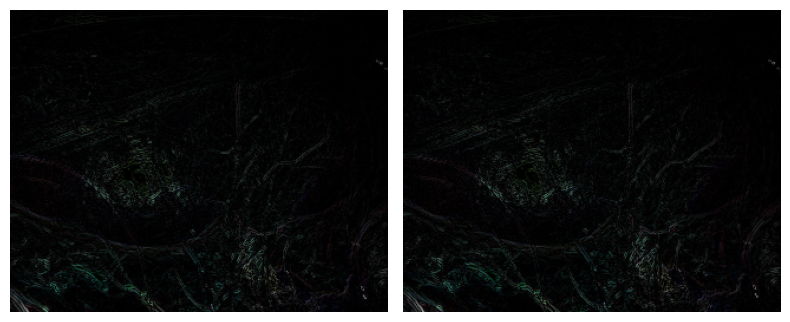

In [4]:
loader = ImageLoader(1, 1)
images = loader.batch([3,4,5])
image_diff = [torch.abs(images[1] - images[0]), torch.abs(images[1] - images[2])]
plot_images(image_diff)

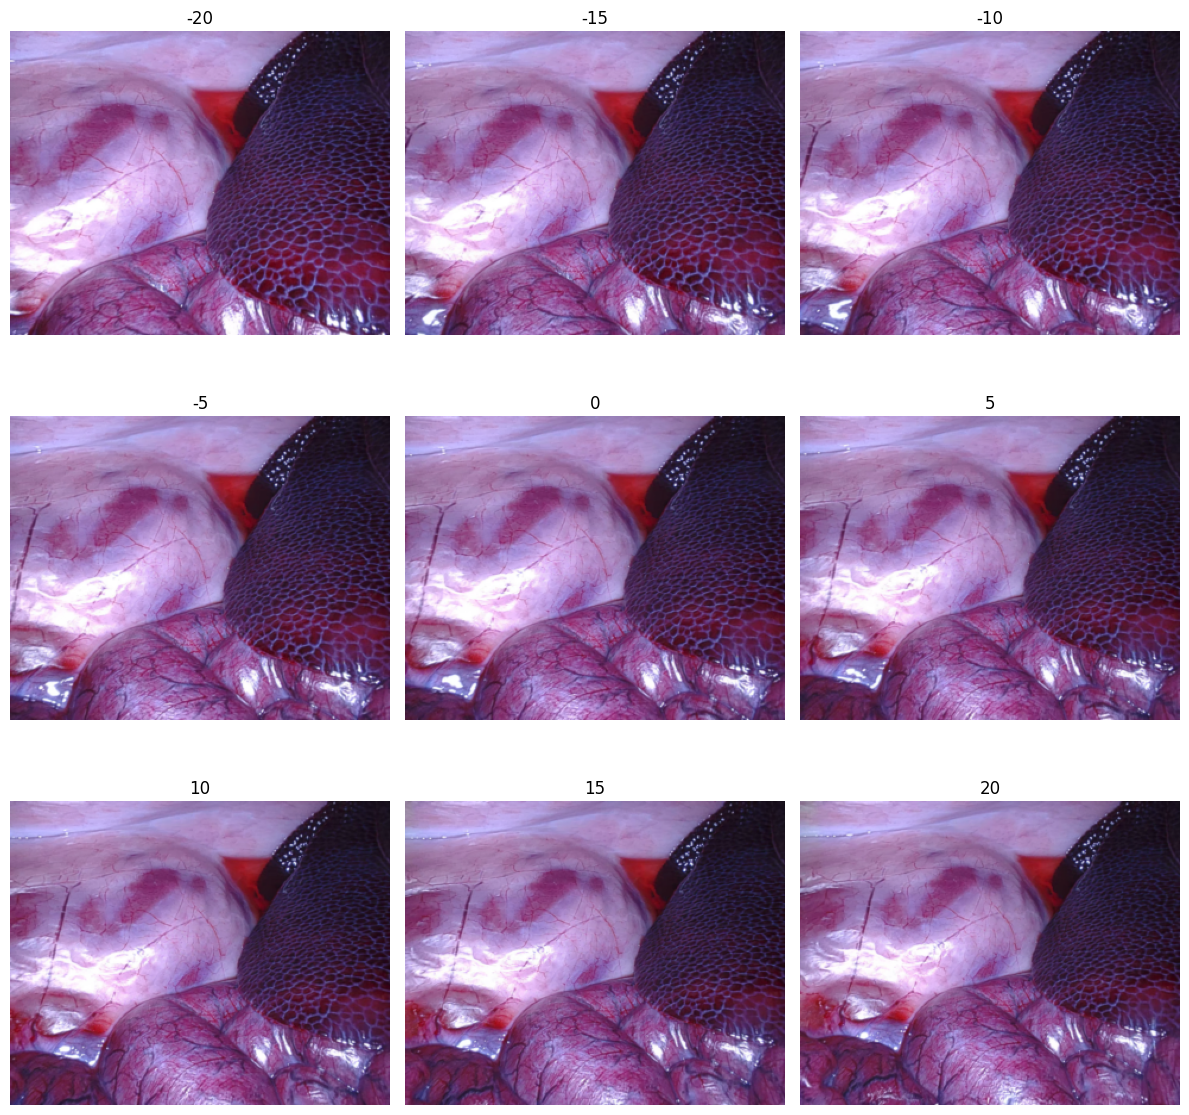

In [19]:
loader = ImageLoader(2, 3)
start = 50
ra = list(range(-20, 20))
ra = list(range(-20, 21, 5))
images = loader.batch([start + i for i in ra])
plot_images(images, 3, titles=[f"{i}" for i in ra])

## 测试Attention

In [22]:
class MaskedDeformableAttention(nn.Module):
    def __init__(self, dim, Wp, num_heads=8, qkv_bias=False, qk_scale=None, attn_drop=0., proj_drop=0., 
                 num_frames=3, num_points=9, patch_shape=None):
        super().__init__()
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = qk_scale or head_dim ** -0.5
        self.num_frames = num_frames
        self.num_points = num_points
        self.dim_head = head_dim
        self.patch_shape = patch_shape  # (Hp, Wp), optional, if None, dynamic in forward

        self.q_proj = nn.Linear(dim, dim, bias=qkv_bias)
        self.k_proj = nn.Linear(dim, dim, bias=qkv_bias)
        self.v_proj = nn.Linear(dim, dim, bias=qkv_bias)
        
        self.offset_proj = nn.Linear(dim, num_heads * num_points * 2)
        
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)
        self.attn_drop = nn.Dropout(attn_drop)
        
        self.suppress_factor = nn.Parameter(torch.tensor(0.5))
        self.Wp = Wp
        
        self.attn = None
        self._init_weights()

    def _init_weights(self):
        nn.init.constant_(self.offset_proj.bias, 0.)
        nn.init.constant_(self.offset_proj.weight, 0.)

    def forward(self, x, mask):
        B, N, T, C = x.shape
        Wp = self.Wp
        Hp = int(N / self.Wp)

        mid_idx = T // 2

        query = x[:, :, mid_idx]
        q = self.q_proj(query).view(B, N, self.num_heads, self.dim_head).permute(0, 2, 1, 3)

        k = self.k_proj(x).view(B, N, T, self.num_heads, self.dim_head).permute(0, 3, 1, 4, 2)
        v = self.v_proj(x).view(B, N, T, self.num_heads, self.dim_head).permute(0, 3, 1, 4, 2)

        h_idx = torch.arange(Hp, device=x.device).float()
        w_idx = torch.arange(Wp, device=x.device).float()
        grid_h, grid_w = torch.meshgrid(h_idx, w_idx, indexing='ij')
        ref_points = torch.stack([grid_w, grid_h], dim=-1).flatten(0, 1)  # (N, 2)
        ref_points = ref_points / torch.tensor([Wp-1, Hp-1], device=x.device) * 2 - 1
        ref_points = ref_points.unsqueeze(0).unsqueeze(2).unsqueeze(2).expand(B, N, self.num_heads, self.num_points, -1)

        offset = self.offset_proj(query).view(B, N, self.num_heads, self.num_points, 2)
        
        # 修正 mask_exp to (B, N, 1, 1, 1)
        mask_exp = mask.unsqueeze(-1).unsqueeze(-1).unsqueeze(-1)  # (B, N, 1, 1, 1)
        offset = offset - self.suppress_factor * mask_exp.repeat(1, 1, self.num_heads, self.num_points, 2) * 0.1

        sampling_locations = ref_points + offset

        output = torch.zeros(B, self.num_heads, N, self.dim_head, device=x.device)

        for t in range(T):
            k_t = k[..., t].permute(0, 1, 3, 2).contiguous().view(B * self.num_heads, self.dim_head, Hp, Wp)
            v_t = v[..., t].permute(0, 1, 3, 2).contiguous().view(B * self.num_heads, self.dim_head, Hp, Wp)

            grid = sampling_locations.view(B * self.num_heads, N * self.num_points, 1, 2)

            sampled_k = F.grid_sample(k_t, grid, mode='bilinear', padding_mode='zeros', align_corners=True)
            sampled_v = F.grid_sample(v_t, grid, mode='bilinear', padding_mode='zeros', align_corners=True)

            sampled_k = sampled_k.view(B, self.num_heads, self.dim_head, N, self.num_points).permute(0, 1, 3, 4, 2)
            sampled_v = sampled_v.view(B, self.num_heads, self.dim_head, N, self.num_points).permute(0, 1, 3, 4, 2)

            attn = (q.unsqueeze(3) @ sampled_k.transpose(-2, -1)) * self.scale
            attn = attn.squeeze(3)

            suppress_weight = 1 - self.suppress_factor * mask.unsqueeze(1).unsqueeze(-1).repeat(1, self.num_heads, 1, self.num_points)
            attn = attn * suppress_weight

            attn = attn.softmax(dim=-1)
            attn = self.attn_drop(attn)
            self.attn = attn

            weighted_v = (attn.unsqueeze(-1) * sampled_v).sum(dim=3)
            output += weighted_v

        output = output / T
        output = output.permute(0, 2, 1, 3).contiguous().view(B, N, C)
        output = self.proj(output)
        output = self.proj_drop(output)
        return output

In [24]:
atten = MaskedDeformableAttention(dim=128, num_heads=4, Wp=16)
inp = torch.randn(8, 320, 5, 128)
mask = torch.randn(8, 320)
atten(inp, mask).shape

torch.Size([8, 320, 128])

## 查看Norm情况

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9883048..0.9997237].


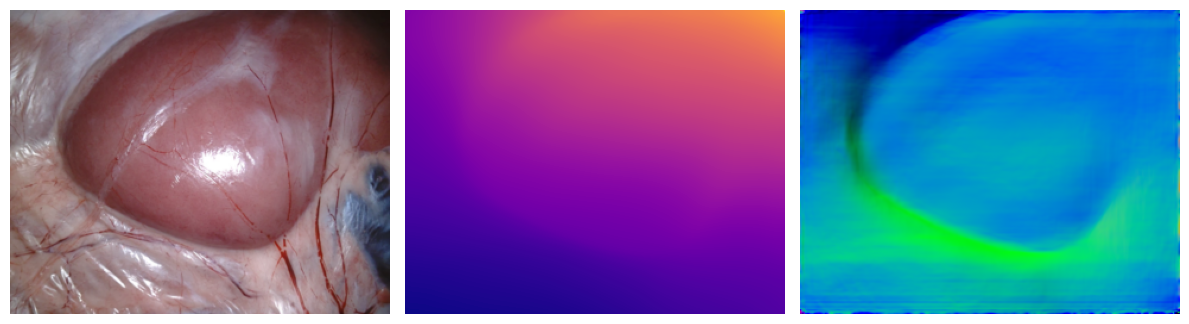

In [23]:
model = networks.DepthSepQKV(resize_shape=(height, width), pretrained_path="./checkpoints/Depth-Anything-V2-Small-hf").to(DEVICE)
image_loader = ImageLoader(6, 2)
image = image_loader.single(1).to(DEVICE)
disp = model(image)
_, depth = layers.disp_to_depth(disp, min_depth, max_depth)
norm_cal = layers.NormalCalculator(height, width, 1).to(DEVICE)

backproject = layers.BackprojectDepth(1, height, width).to(DEVICE)
points_3d = backproject(depth, inv_K)
norm = norm_cal.forward_from_points(points_3d)
plot_images([image, depth, norm], cmaps=["", "plasma", "viridis"])

In [ ]:
# points_3d.shape: torch.Size([1, 4, 81920])
# norm.shape: torch.Size([1, 3, 256, 320])
points = points_3d[:, :-1]
points = rearrange(points, "B C (H W) -> B C H W", H=256, W=320)


torch.Size([1, 3, 256, 320])

In [ ]:
a = torch.tensor([
	[
		[
			[1,2,3],
			[2,3,4],
			[4,5,6],
			[0,1,2]
		]
	]
])

torch.Size([1, 1, 4, 3])

In [ ]:
# 我现在有两个tensor，形状为torch.Size([1, 3, 256, 320])，分别为a,b。a代表的是这里256，320分别代表H，W。3代表的不止是通道，更是代表每个点上的向量，我这里希望求得，每个点的向量

In [50]:
pc = rearrange(points, "B C H W -> B H W C", H=256, W=320)
pc = pc[0]

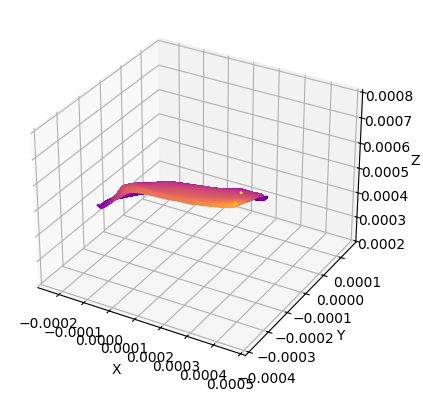

In [53]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D   # noqa: F401  仅注册 3D 投影

pts = pc.detach().cpu().numpy()
H, W, _ = pts.shape
xyz = pts.reshape(-1, 3)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
# 用 z 值着色
z = xyz[:, 2]
ax.scatter(xyz[:, 0], xyz[:, 1], xyz[:, 2],
           c=z, s=1, cmap='plasma')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.show()